<a href="https://colab.research.google.com/github/jcmacuacua/codigo-desenvolvimento-ndvi-evi/blob/master/NDVI2_DesenvolvimetoVV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Apresentacao: **Desenvolvimento de Aplicacoes Espaciais** 2020-Jaime Carlos Macuacua

## **Google Earth Engine** é uma plataforma online para o desenvolvimento de análises espaciais usando um extenso banco de imagens aéreas.

Irei fazer a **COMPOSIÇÃO DA IMAGEM** e **CALCULAR OS ÍNDICES**, comummente usados, **NDVI** e **EVI**, usando a linguagem de programação através do Google Colab. O Google Colab funciona como um Jupyter Notebook, onde diferentes linhas de código podem ser executados em diferentes células, facilitando a avaliação dos resultados obtidos.

O pacote da API do Python na plataforma Google Earth Engine é chamado **ee**. Ele deve ser importado e inicializado para cada nova sessão de script do Python. 

O primeiro passo deve-se importar a biblioteca de **ee** e autenticar

Importou-se o modulo **IPython.display**  que contém a função Image - o módulo exibe os resultados de um URL que representa uma imagem gerada a partir de uma chamada para a função getThumbUrl do Earth Engine.

Importou -se a biblioteca **folium** - que facilita a visualização dos dados em um mapa interativo. 

Também importou-se a biblioteca **matplotlib** para facilitar a visualização de dados em forma de gráficos.


In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Bmopgn3FKB-stvXEBAkndJBZ2dBkpwp_tisL-dAGu5s&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/4AEqME-eZngFJ5Oz6OZerfYVTbDqrcNbBKG9QgRseMhljumXuVTn8r4

Successfully saved authorization token.


In [ ]:
from IPython.display import Image
import ee, folium
ee.Initialize()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

Define-se a area de interesse, atraves das cooordenadas. Neste caso temos 4 cooordenadas que cobre **Paraná**. Chama-se a coleção de imagem Landsat (**ee.ImageCollection**). Ainda filtra-se o efeito das nuvens, neste caso a baixo de 2% e por fim filtra-se o período para a análise. 

In [ ]:
area_of_interest = ee.Geometry.Rectangle([-54.6193046378124905,-26.7171220079271947, -48.0235374346286932,-22.5162951645320959])
landsat8_collection = ee.ImageCollection('LANDSAT/LC8_L1T_TOA').filterMetadata('CLOUD_COVER', 'less_than', 2).filterDate('2016-01-01', '2018-04-19').min()
landsat8_collection = landsat8_collection.slice(0,9)
imagem = landsat8_collection.clip(area_of_interest)

No Earth Engine, muitas das informações estão salvas no servidor, logo, para acessá-las é necessário usar a função **getInfo()**.

O código abaixo irá carregar uma coleção de imagens considerando filtros de data e localização. Em seguida, irá se imprimir as informações sobre quantas imagens. 

In [ ]:
imagem = ee.ImageCollection('LANDSAT/LC8_L1T_TOA')\
  .filterDate('2016-01-01', '2018-04-19')\
  .filterBounds(ee.Geometry.Rectangle(-54.6193046378124905,-26.7171220079271947, -48.0235374346286932,-22.5162951645320959))
print("Quantidade de Imagens: ", imagem.size().getInfo())

 

Quantidade de Imagens:  645


O código abaixo irá carregar uma coleção das datas disponiveis na coleção de imagens. Em seguida, irá se imprimir as informações sobre as: **Datas  disponiveis.**

In [ ]:
def ymdList(imgcol):
    def iter_func(imagem, newlist):
        date = ee.Number.parse(imagem.date().format("YYYYMMdd"));
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).reduce(ee.Reducer.frequencyHistogram()).getInfo().keys())

In [ ]:
print('Datas disponíveis: ', ymdList(imagem))

Datas disponíveis:  ['20160102', '20160104', '20160109', '20160111', '20160113', '20160116', '20160118', '20160120', '20160125', '20160127', '20160129', '20160201', '20160203', '20160205', '20160210', '20160212', '20160214', '20160217', '20160219', '20160221', '20160226', '20160228', '20160301', '20160304', '20160306', '20160308', '20160313', '20160315', '20160317', '20160320', '20160322', '20160324', '20160329', '20160331', '20160402', '20160405', '20160407', '20160409', '20160414', '20160416', '20160418', '20160421', '20160423', '20160425', '20160428', '20160430', '20160502', '20160504', '20160507', '20160509', '20160511', '20160516', '20160518', '20160523', '20160525', '20160527', '20160601', '20160603', '20160608', '20160610', '20160612', '20160617', '20160619', '20160624', '20160626', '20160628', '20160703', '20160705', '20160707', '20160710', '20160712', '20160714', '20160719', '20160721', '20160723', '20160726', '20160728', '20160730', '20160804', '20160806', '20160811', '201608

Tendo as imagens da área de estudo, já podem ser visualizadas. Há várias formas de visualizar imagens do Earth Engine em python, no presente estudo usou-se a biblioteca Folium.

Primeiro fez-se a **composição de bandas**. A combinação das bandas depende do objectivo do trabalho, mas é preciso conhecer as características do sensor e de cada banda. Por exemplo: para fazer a composição bandas pode-se ter em enfase a cor natural, ou seja, a composição falsa cor - RGB 4,3,2. No entanto, a composição falsa  cor para **áreas urbanas** é 7, 6, 4; Infravermelho **(vegetação)** 5, 4, 3; **Agricultura** 6, 5,2; **Penetração atmosférica** 7, 6, 5. 

In [ ]:
vis = {
    'bands': ['B7', 'B6', 'B4'],
    'min': 0,
    'max': 0.5,
    'gamma': [0.95, 1.1, 1],
    'region':area_of_interest} 
image = landsat8_collection.clip(area_of_interest)
mapid = image.getMapId(vis)
map = folium.Map(location=[-26.7171220079271947, -48.0235374346286932],zoom_start=9, height=500,width=700)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Landsat 8 ',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Há diferentes formas de calcular o NDVI no Earth Engine, a mais fácil é chamando a função **normalizedDifference()**, aplicada no presente trabalho, outra forma usa-se a função expressão que possibilita maior flexibilidade para os cálculos: **NDVI** = (NIR — Red)/(NIR + Red). 

Para o cálculo de Enhanced Vegetation Index (**EVI**) usou-se a função expressão: Gain_Factor*((NIR-RED)/(NIR+C1*RED-C2*BLUE+L)). Lembrar que os valores dos índices variam de -1 a +1. 

NDVI - é sensível à presença de clorofila na vegetação.

EVI - sensível às variações estruturais do dossel em regiões com alta densidade de biomassa, por ter sido melhorado por meio da redução da influência da atmosfera e da dissociação do sinal de fundo do dossel vegetal. 



In [ ]:
def NDVI(image):
    return image.normalizedDifference(['B5', 'B4'])

def EVI(image):
    # L( ajuste de fundo do dossel vegetal L=1)
    # C1,C2(Coeficientes de ajuste da influência dos aerossóis (C1=6; C2=7,5).
    # G=GainFactor(fator de ganho, geralmente assume valor de 2,5)
    gain_factor = ee.Image(2.5);
    coefficient_1 = ee.Image(6);
    coefficient_2 = ee.Image(7.5);
    l = ee.Image(1);
    nir = image.select("B5");
    red = image.select("B4");
    blue = image.select("B2");
    evi = image.expression(
        "Gain_Factor*((NIR-RED)/(NIR+C1*RED-C2*BLUE+L))",
        {
            "Gain_Factor":gain_factor,
            "NIR":nir,
            "RED":red,
            "C1":coefficient_1,
            "C2":coefficient_2,
            "BLUE":blue,
            "L":l
        }
    )
    return evi

Aqui sao apresentados os dois índices calculados (NDVI e EVI) na funcao acima. 

In [ ]:
ndvi = NDVI(landsat8_collection)
evi = EVI(landsat8_collection)

O código que se segue permite visualizar o NDVI da área de estudo e definiu se o palette das cores - neste caso assumiu-se as seguintes cores [blue, white, green].

In [ ]:
image = ndvi.clip(area_of_interest)

vis_ndvi = {'min':-1,'max':1, 'palette': ['blue', 'white', 'green'],'size':'800',
           'region':area_of_interest}

mapid = image.getMapId(vis_ndvi)

map = folium.Map(location=[-26.7171220079271947, -48.0235374346286932],zoom_start=9, height=500,width=700)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='NDVI',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

O código que se segue permite visualizar o EVI da área de estudo e definiu se também palette de cores - neste caso assumiu-se as seguintes cores: [blue, white, green].

In [ ]:
image = evi.clip(area_of_interest)

vis_evi = {'min':-1,'max':1, 'palette': ['blue', 'white', 'green'] ,'size':'800',
           'region':area_of_interest}

mapid = image.getMapId(vis_evi)

map = folium.Map(location=[-26.7171220079271947, -48.0235374346286932],zoom_start=9, height=500,width=700)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='EVI',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

Algumas funções do Earth Engine produzem dados tabulares que podem ser plotados por pacotes de visualização de dados, como é o caso da **biblioteca matplotlib**.

Tendo a imagem , selecionamos as bandas de interesse, dimensionar-as, fazendo uma amostra (pode-se 400 pontos ou mais) e organiza a amostra numa lista e salve a lista e depois plotar o gráfico.

In [ ]:
imagem = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

samp_fc = imagem.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=400)

samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

samp_data = samp_list.getInfo()

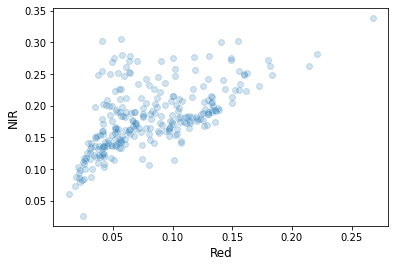

In [ ]:
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()